# Conservation Information for Shared Print Retention Programs: A Valuation of MARC 583 in the HathiTrust Digital Library

Some explantion goes here

In [153]:
import pandas as pd
import numpy as np
import numpy
import nltk

import simplejson as json
import csv
import os
import glob
import copy

import matplotlib.pyplot as plt
plt.close('all')

import re

Each CSV is cast to a dataframe and concatenated as a list. Dataframes will be accessible by iterating over the list. 

With each transformation to the dataset, the dataframes are assigned to a new variable so it can be accessed at a later point if needed. Simple variable assignment, using new_list = old_list, copies only the list, thus each dataframe continues to be modified. Instead, copy.deepcopy(x) is used in order to capture both the list and its objects, the dataframes. 

Naming Conventions for variable assignments:   
Data/ObjectType_Slice_Purpose or dfName, sName  
Ex. Plot_583_WCounts, dfStats, s583

In [154]:
rootdir = r'C:\\Users\\kayle\\OneDrive\\Documents (OneDrive)\\ISchool\\2019 Summer\\Oxford\\HTRC-workingfiles\\HTRC-Meta-All'

path_list = []

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        filepath = os.path.join(subdir, file)
        path_list.append(filepath)

dataframes = [] 
for path in path_list:
    dataframes.append(pd.read_csv(path,
                                 encoding='utf-8',
                                  usecols=['001',
                                           '010', # LCCN
                                           '035',
                                           '040', # Cataloging source
                                           '041', # Language code
                                           '100', # author
                                           '245', # Title stmt
                                           '250', # Edition stmt
                                           '260', # Pub info
                                           '300', # Phys desc
                                           '500', # Gen notes
                                           '520', # Annotation/summary
                                           '561', # Ownership
                                           '563', # Binding
                                           '583', # Action
                                           '600', 
                                           '610', 
                                           '611', 
                                           '648', 
                                           '650', # Topical Subject
                                           '655',
                                           '974'])) # Zephir's Hathi-specific

In the interest of faster processing, only MARC fields which might be of interest are read in from the files. 

The 974 field is not an official MARC field, but one added by Zephir, the CDL that processes HathiTrust metadata. c indicates the holding institution and u contains the unique id. Codemapping of available institutions is available [online](https://github.com/Bookworm-project/Bookworm-MARC/issues/1).

Few records in the HTDL contain the local holdings information in the 850 field. This study must rely on Zephir's metadata instead of the original records for this information.

# Munging
Clean up the textual data for all cells: lowercase, punctuation, tokenize

In [155]:
#! Use dictionary pattern to extract the desired subfield values
#! assign these subfields to columns to make them easily transformable

### Scratch ###
# level 1: all the keys, values in one column
#      level 2: iterate over the list of dictionaries
#          level 3: iterate over the items in the dictionaries


# for label, content in df['974'].items():
#     t = content
#     new_list = [i[0] for i in t]
#     print(label)
#     print(content, sep='\n')

In [156]:
# Convert "Missing" to empty string. 

i = 0

for frame in dataframes:
    dataframes[i] = dataframes[i].replace(to_replace='MISSING', value='')
    i += 1

In [157]:
# lowercase and strip punctuation
#!!! this code applies functions to the entire dataframe, but it should ONLY apply to the values

def clean_lower(self):
    return self.str.lower()

def clean_punct(self):
    return self.str.replace('[^\w\s]','')

dfClean = copy.deepcopy(dataframes)

i = 0

for frame in dfClean:
    dfClean[i] = dfClean[i].select_dtypes(include='object').apply(clean_lower)
    dfClean[i] = dfClean[i].select_dtypes(include='object').apply(clean_punct)
    i += 1
dfClean[2].head()    

,010,035,040,041,100,245,250,260,300,500,...,561,563,583,600,610,611,648,650,655,974
0,a 11001800,a ocolc2419573,a dlc c ppn d ser d clu,,a day holman d 18651935,a the skipper and the skipped b being the shor...,,a new york a london b harper brothers c 1911,a 2 p l 416 p 1 l b front c 20 cm,,...,,,,,,,,,,8 iaskipperandskippe00dayhiala b uc c isrlf d ...
1,a 24011124,a rlinmiug84b29275,c oku d oku d miu,,a decosta b f q benjamin franklin d 18311904,a hiawatha b or the story of the iroquois sag...,,a new york b a d f randolph co c 1873,a 30 p 1 l c 15 cm,,...,,,,a hiawatha d 15th cent,,,,,,b miu c miu d 20130819 s litdlpsdc u miunabf15...
2,a 20013065,a ocolc2640900,a dlc c ibs d mc d ocl d clu,,a dell ethel m q ethel may d 18811939,a the top of the world c by ethel m dell,,a new york b putnam c 1920,a ix 562 p c 20 cm,,...,,,,,,,,,,8 iatopofworld00delliala b uc c isrlf d 201811...
3,,a ocolc2736597,a ksu c ksu d mc d clu,,a de mille james d 18371880,a the cryptogram b a novel c by james de mille,,a new york b harper brothers publishers c 1871,a 1 pl 1261 1 p 2 l b ill c 232 cm,a bound in brown cloth stamped in gold and bli...,...,,,,,,,,,,8 iacryptogramnovel00demiiala b uc c isrlf d 2...
4,a 09028954,a ocolc364168,a dlc c wsu d ser d cuy d zephir,,a de morgan william frend d 18391917,a it never can happen again c by william de mo...,,a new york b h holt and company c 1909,a c 19 cm,,...,,,,,,,,,,8 iaitnevercanhappen00demoiala b uc c isrlf d ...


In [158]:
# Stopwords

from nltk.corpus import stopwords
stop = stopwords.words('english')

pat = r'\b(?:{})\b'.format('|'.join(stop))

dfStop = copy.deepcopy(dfClean)

def clean_stop(self):
    self.str.replace(pat,'')
    self.str.replace(r'\s+', ' ')
    return self

i = 0

for frame in dfStop:
    dfStop[i] = dfStop[i].select_dtypes(include=object).apply(clean_stop)
    i += 1

# Quantitative Study

* Percentage of records with data
* Amount of data per record (min, max, std)
* Data coverage by subject area
* Word Frequencies: 
    * most common words in the column
    * most common words by subject area

In [159]:
# Count Characters & Create Columns
# Creates new dataframes with character counts for the relevant columns
# other data remains intact

dfCounts = copy.deepcopy(dfClean)

i = 0
for frame in dfCounts:
    dfCounts[i]['500'] = dfCounts[i]['500'].str.len()
    dfCounts[i]['561'] = dfCounts[i]['561'].str.len()
    dfCounts[i]['563'] = dfCounts[i]['563'].str.len()
    dfCounts[i]['583'] = dfCounts[i]['583'].str.len()
    i += 1

In [160]:
# Number of Records with Data in the 583 Column
# Percentage of Records with Data in the 583 Column

i = 0
Data_583_Count = 0
Data_583_Perc = 0

for frame in dfCounts:
    s = pd.Series(dfCounts[i]['583']) # a mutable series
    Data_583_Count = Data_583_Count + dfCounts[i]['583'].where(s != 0).count()
    Data_583_Perc = Data_583_Perc + dfCounts[i]['583'].where(s != 0).count()/dfCounts[i]['583'].count()
    i += 1
    
print(Data_583_Count)
print(Data_583_Perc)

124
0.012400000000000001


In [161]:
# STATS: Create a dataframe showing record count, min, max, mean, and std
# Generate one row per file


# stats = pd.DataFrame(dfCounts['583'])

# for i in ActDF.index:
#     stats = stats_583.ActDF['583_Characters'](stats)

# stats = stats.describe()
# stats

i = -1
Data_583_Total = 0
Data_583_Max = 0
Data_583_Min = 0 
Data_583_Mean = 0 
Data_583_Std = 0

for frame in dfCounts:
    Data_583_Total = Data_583_Total + dfCounts[i]['583'].count()
    Data_583_Max = Data_583_Max + dfCounts[i]['583'].max()
    Data_583_Min = Data_583_Min + dfCounts[i]['583'].min()
    Data_583_Mean = Data_583_Mean + dfCounts[i]['583'].mean()
    Data_583_Std = Data_583_Std + dfCounts[i]['583'].std()
    
dfStats_583 = pd.DataFrame({'Total': Data_583_Total, 
                            'Max': Data_583_Max, 
                            'Min': Data_583_Min, 
                            'Mean': Data_583_Mean, 
                            'Std': Data_583_Std,
                            'With_Data': Data_583_Count,
                            'With_Data_Perc': Data_583_Perc}, index=[0]).T
dfStats_583

,0
Total,30000.000000
Max,228.000000
Min,0.000000
Mean,0.771600
Std,9.927119
With_Data,124.000000
With_Data_Perc,0.012400


In [162]:
#! Output to CSV

# exportStats = dfStats_583.to_csv(r'Path name here.csv', index=False)

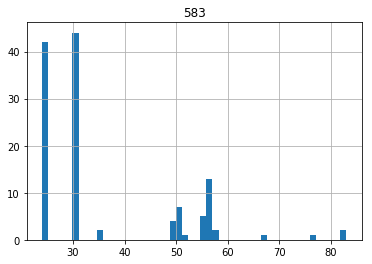

In [163]:
# Plot Character Counts

# Concat numerical data in 583 Columns from all files
i = 0

dfWCounts_583 = copy.deepcopy(dfCounts)

for frame in dfWCounts_583:
    dfWCounts_583[i] = dfWCounts_583[i].filter(['583'], axis=1)
    i += 1
    
dfWCounts_583 = pd.concat(dfWCounts_583) 

# Generate series
s_583 = pd.Series(dfWCounts_583['583'])

# Generate Plot
Plot_WCounts_583 = dfWCounts_583.where(s_583 > 2).hist(column='583', bins=50)

In [164]:
## Plot frequency of words as tokens

# Tokenize
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

# extract each series into dictionary or list and tokenize 
# iterate through dataframe by index

### 500 General Notes ###
tokens_500 = []

for df in dfStop:
    frame = df
    for i in frame.index:      
        t = str(frame['500'][i])
        s_t = t.split()
        tokens_500.append(s_t)
    
word_list_500 = []

for l in tokens_500:
    word_list_500 = word_list_500 + l

    
### 561 Ownership ###
tokens_561 = []

for df in dfStop:
    frame = df
    for i in frame.index:      
        t = str(frame['561'][i])
        s_t = t.split()
        tokens_561.append(s_t)
    
word_list_561 = []

for l in tokens_500:
    word_list_561 = word_list_561 + l

    
### 563 Binding ###
tokens_563 = []

for df in dfStop:
    frame = df
    for i in frame.index:
        t = str(frame['563'][i])
        s_t = t.split()
        tokens_563.append(s_t)

word_list_563 = []

for l in tokens_563:
    word_list_563 = word_list_563 + l


### 583 Action Notes ###
tokens_583 = []

for df in dfStop:
    frame = df
    for i in frame.index:
        t = str(frame['583'][i])
        s_t = t.split()
        tokens_583.append(s_t)

word_list_583 = []

for l in tokens_583:
    word_list_583 = word_list_583 + l

### Subject fields -- access via tokens? or k, v pairs?

In [165]:
# Cast wordcounts lists to dictionaries
# If we find we want to access the frequency of a given word later, this will enable us to do that

from collections import Counter

counter500 = Counter(word_list_500)
counter561 = Counter(word_list_561)
counter563 = Counter(word_list_563)
counter583 = Counter(word_list_583)
counter583['digitized']

7

In [166]:
# Frequency of Words, as Tokens

top_N = 30

word_dist = nltk.FreqDist(word_list_583)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                   columns=['Word', 'Frequency'])
print(rslt)

          Word  Frequency
0            a        124
1            3         57
2            c         56
3            k         50
4            l         47
5        sloan         44
6    candidate         44
7           lp         44
8         tier         44
9         will         43
10    reformat         42
11      071690         31
12  rubenstein         22
13     library         22
14        copy         22
15      former         22
16        call         22
17      number         22
18           1         13
19       jantz         11
20           2          8
21         pda          8
22           5          8
23   digitized          7
24        geus          7
25           x          7
26      public          7
27      domain          7
28           f          6
29           e          5


In [167]:
# Understanding context

# Quick Check
# for df in dfStop:
#     frame = df
#     for i in frame.index:
#         a = str(frame['583'][i])
#         if 'tier' in a:
#             print(a)
#         else:
#             continue
            
# Get the whole row
checkRows = copy.deepcopy(dfStop)

x = 0

checker = []

for df in checkRows:
    frame = df
    frame = frame[['tier' in i for i in frame['583']]]
    checker.append(frame)
    checkRows = pd.concat(checker)
checkRows

,010,035,040,041,100,245,250,260,300,500,...,561,563,583,600,610,611,648,650,655,974
188,,9 2568112,a mb c miac d miac d ocolc d ncrs d mh d cstrl...,,a adams w h davenport q william henry davenpor...,a the buried cities of campania or pompeii and...,,a london a new york b t nelson and sons c 1873,a x 282 p b ill c 19 cm,,...,,,a sloan candidate k lp l tier 1,,,,,,,8 iaburiedcitiesofca00adamiala b cmalg c gri d...
8047,a 03005493,9 88b24875,c miu d miu d cmalg,,a akerman john yonge d 18061873,a an archæological index to remains of antiqui...,,a london b j r smith c 1847,a xii p 1 l 204 p b illus pl c 22 cm,,...,,,a sloan candidate k lp l tier 3,,,,,,,8 iaarchologicalinde00aker b cmalg c gri d 201...
8048,a 03005493,9 88b24875,c miu d miu d cmalg,,a akerman john yonge d 18061873,a an archæological index to remains of antiqui...,,a london b j r smith c 1847,a xii p 1 l 204 p b illus pl c 22 cm,,...,,,a sloan candidate k lp l tier 3,,,,,,,8 iaarchaelogicalind00akerrich b uc c inrlf d ...
8189,a 10021475,9 89b1200,c miu d miu d cmalg,,a smith charles roach d 18071890,a collectanea antiqua b etchings and notices ...,,a london b jr smith c 18481880,a 7 v b ill some col plans c 23 cm,a chiefly articles on roman remains coins orna...,...,,,a sloan candidate k lp l tier 3,,,,,,a etchings z england y 19th century 2 aat,8 iagri_33125009314366 b cmalg c gri d 2017101...
8190,a 10021475,9 89b1200,c miu d miu d cmalg,,a smith charles roach d 18071890,a collectanea antiqua b etchings and notices ...,,a london b jr smith c 18481880,a 7 v b ill some col plans c 23 cm,a chiefly articles on roman remains coins orna...,...,,,a sloan candidate k lp l tier 3,,,,,,a etchings z england y 19th century 2 aat,8 iagri_33125009314713 b cmalg c gri d 2017101...
8191,a 10021475,9 89b1200,c miu d miu d cmalg,,a smith charles roach d 18071890,a collectanea antiqua b etchings and notices ...,,a london b jr smith c 18481880,a 7 v b ill some col plans c 23 cm,a chiefly articles on roman remains coins orna...,...,,,a sloan candidate k lp l tier 3,,,,,,a etchings z england y 19th century 2 aat,8 iagri_33125009314721 b cmalg c gri d 2017101...
8192,a 10021475,9 89b1200,c miu d miu d cmalg,,a smith charles roach d 18071890,a collectanea antiqua b etchings and notices ...,,a london b jr smith c 18481880,a 7 v b ill some col plans c 23 cm,a chiefly articles on roman remains coins orna...,...,,,a sloan candidate k lp l tier 3,,,,,,a etchings z england y 19th century 2 aat,8 iagri_33125009314739 b cmalg c gri d 2017101...
8193,a 10021475,9 89b1200,c miu d miu d cmalg,,a smith charles roach d 18071890,a collectanea antiqua b etchings and notices ...,,a london b jr smith c 18481880,a 7 v b ill some col plans c 23 cm,a chiefly articles on roman remains coins orna...,...,,,a sloan candidate k lp l tier 3,,,,,,a etchings z england y 19th century 2 aat,8 iagri_33125009315009 b cmalg c gri d 2017101...
8194,a 10021475,9 89b1200,c miu d miu d cmalg,,a smith charles roach d 18071890,a collectanea antiqua b etchings and notices ...,,a london b jr smith c 18481880,a 7 v b ill some col plans c 23 cm,a chiefly articles on roman remains coins orna...,...,,,a sloan candidate k lp l tier 3,,,,,,a etchings z england y 19th century 2 aat,8 iagri_33125009314770 b cmalg c gri d 2017101...
8195,a 10021475,9 89b1200,c miu d miu d cmalg,,a smith charles roach d 18071890,a collectanea antiqua b etchings and notices ...,,a london b jr smith c 18481880,a 7 v b ill some col plans c 23 cm,a chiefly articles on roman remains coins orna...,...,,,a sloan candidate k lp l tier 3,,,,,,a etchings z england y 19th century 2 aat,8 iagri_33125009314820 b cmalg c gri d 2017101...


# Coverage by Subject Area

For each subject field, we will gather the LCSH listed for rows where there is 583 data. From there, we can examine trends in the quantity of documentation by subject area. 


In [174]:
### Create dataframes where both conditions are met--data in 583 and subject data

# 650, general subject field, is the primary field of interest
# 655, which looks at the form, may be of interest
# 600, persons

### 650
#! only 'a'

df650 = copy.deepcopy(dfClean)
filtered_frames = []


for df in df650:
    frame = df
    frame.replace("", numpy.nan, inplace=True)
    frame = frame[frame['583'].notnull() & 
                  frame['650'].notnull()].drop(columns=['600','610','611','648','655'])
    filtered_frames.append(frame)
    df650 = pd.concat(filtered_frames)


print(len(df650))

72


In [181]:
# Evaluate which subjects have the most conservation/preservation data

# From this new conditional dataframe, we examine the most frequent subjects to appear
## If we do by Ngram, it will think words in sequence are connected... but they aren't necessarily
## We can evaluate subjects by token and remove tokens which are 1 character long (subfields)

# Step 1: Generate Tokens for 650 Subject Field
tokens_650 = []

for i in df650.index:
    t = str(df650['650'][i])
    s_t = t.split()
    tokens_650.append(s_t)

word_list_650 = []

for l in tokens_650:
    word_list_650 = word_list_650 + l

counter650 = Counter(word_list_650)
counter650

    
### Word Frequency
top_N = 30

word_dist = nltk.FreqDist(word_list_650)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                   columns=['Word', 'Frequency'])
print(rslt)


### this method requires some fine-tuning. 
## people don't typically use multiple 'a' to delimit fields,
# could we use POS tagging to determine what is "american literature"?

           Word  Frequency
0             a         72
1             z         66
2        states         35
3    literature         33
4      american         31
5      southern         31
6       history         13
7             v         13
8             x         12
9           art         10
10        italy          9
11      african          6
12    americans          6
13        early          6
14    biography          5
15     painting          5
16          and          4
17       naples          4
18     catalogs          4
19       united          4
20       church          4
21      england          4
22        works          4
23           to          4
24         1800          4
25      germans          3
26    catacombs          3
27         rome          3
28      hunting          2
29  mississippi          2


# Qualitative Study

* What are the different ways the 583 field is being used? Group by institution
* How is the condition status of items recorded?
* How do you evaluate the condition status of items which are *not* using the tiered system?
    * can you apply a sentiment analysis model?
    * can you train a sentiment analysis model for conservation/preservation?
    * can you then rank items--rank them by condition, by subject area, by geographic location?
* Would such a study enable us to understand what subject areas are under-represented? Will we see trends in preservation problems by geographic region?

In [ ]:
# Examine use of 583 by Institution

## 583 tokens, groupby([974c])  (institution)
# find character count by institution -- who says more?
# find mostfrequent tokens or bigrams for each institution


In [ ]:
# Examine how the condition status, $l, is recorded

# use overall
# use by institution


In [ ]:
# Classify condition status with sentiment analysis

# Get a sentiment score for each item with 583 data
## Iterate over rows, get the sentiment score
## Store sentiments in df? 

# Does it work?

# Add to library

# Examine by subject


In [196]:
from textblob import TextBlob
zen = TextBlob("Hello, I've come here for an argument.")
for sentence in zen.sentences:
    print(sentence.sentiment)

Sentiment(polarity=0.0, subjectivity=0.0)


In [200]:
field_list = []

for df in dfClean:
    frame = df
    frame.replace("", numpy.nan, inplace=True)
    frame = frame[frame['583'].notnull()]
    for i in frame['583'].index:
        fields = str(frame['583'][i])
        field_list.append(fields) 

sentiments = []
senti = TextBlob(str(field_list))
for field in senti.sentences:
    sentiments.append(field.sentiment)
    
sentiments

[Sentiment(polarity=0.0, subjectivity=0.016091954022988506)]

In [186]:
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# analyzer = SentimentIntensityAnalyzer()

# i = 0 
# field = []
# vs_compound = []
# vs_pos = []
# vs_neu = []
# vs_neg = []
# blob_frames = [] # holds the dataframes so the value isn't overwritten

# dfBlob = copy.deepcopy(dfClean)

# for df in dfBlob:
#     frame = df
#     field.append(frame['583'])
#     vs_compound.append(analyzer.polarity_scores(frame[i]['583']['compound']))
#     vs_pos.append(analyzer.polarity_scores(frame[i]['583']['pos']))
#     vs_neu.append(analyzer.polarity_scores(frame[i]['583']['neu']))
#     vs_neg.append(analyzer.polarity_scores(frame[i]['583']['neg']))
#     blob_frames.append(frame)
    
# dfSenti = DataFrame({'field': field, 
#                      'compound,': vs_compound, 
#                      'positive': vs_pos, 
#                      'neutral': vs_neu, 
#                      'negative': vs_neg})
# dfSenti

In [ ]:
# select representative chunks -- 10k for each 


# specifics -- formally for this project
## numerically for this project
# accumulate for files

## completion of preservation conservation for one subset
# concat
# save the CSV... lots of CSVs... to_csv

# Analysis

In [279]:
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt
# text = (word_list_500x610) # does not work with 583 ?
# wordcloud = WordCloud(
#     width = 3000,
#     height = 2000,
#     background_color = 'black').generate(str(text))
# fig = plt.figure(
#     figsize = (40, 30))
# plt.imshow(wordcloud, interpolation = 'bilinear')
# plt.axis('off')
# plt.tight_layout(pad=0)
# plt.show()

# # use fit_words to generate wordcoud from words and frequencies

# Scratch
* workflows to assess the quality of shared databases
* what are the challenges to identifying what is *in* the HT database to begin with?
    * lack of identifying numbers (OCLC)
    * title variants.
    * when a library deposits, it's too much work to check manually... 
    * workflow to identify gaps in holdings and check against them when people deposit
        * mine bibliographies that are probably already on HT?
        * from author {'name': birth-death}
        * 
* I'm assuming we can, with some accuracy, assess the prevalence of copy cataloging. We have the 850 (holding inst) and the cataloging source. Pull the records where they do not match. We can assess these records for the quality of the metadata and rate of error. We can see how frequently things like copy-specific metadata for rare books are carried over. Conservators, like those at the Folger, believe that this is *very* prevalent, to the point that each rare books librarian seems suspicious of records from every other institution. Is this fair?
    

In [ ]:
# Ngram Frequency
from sklearn.feature_extraction.text import CountVectorizer

### 500
# word_vectorizer = CountVectorizer(ngram_range=(1,2), analyzer='word')
# sparse_matrix = word_vectorizer.fit_transform(dfClean['500'])
# frequencies = sum(sparse_matrix).toarray()[0]
# nGram500 = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])

### 583
i = 0
df583 = copy.deepcopy(dfClean)

for frame in df583:
    df583[i] = df583[i].filter(['583'], axis=1)
    i += 1

df583 = pd.concat(df583)

 
word_vectorizer = CountVectorizer(ngram_range=(1,2), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(df583['583'])
frequencies = sum(sparse_matrix).toarray()[0]
nGram583 = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])

#! Come back to this
# sort bigrams, trigrams by frequency
# use these tokens in order to provide context for the sentiment analysis part

In [183]:
# I'm curious, what would happen if you tried stylometry on the 500 fields? 
# We talk about the hiddenness of the librarian and the importance of meta-metadata
# Can you find the cataloger's fingerprint? or do we all sound the same?